# 2D Gaussian Process Regression Comparison (with ARD)

This notebook compares two different implementations of Gaussian Process Regression in a 2D scenario:
1. `GPR_efficient`: My optimized implementation, now upgraded with an ARD (Automatic Relevance Determination) kernel.
2. `GPy`: A popular and robust third-party GP library.

The ARD kernel allows the model to have a separate length-scale parameter for each input dimension ('TV' and 'Radio'), which can lead to a much better fit. We measure the execution time and visualize the resulting GP surfaces to see how my implementation compares to the GPy reference.

In [10]:
# --- 1. Import Libraries ---
import time
import GPy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

# Import my custom Gaussian Process implementations
from GPR_efficient import GaussianProcessEfficient

In [11]:
# --- 2. Data Loading and Preparation ---

# Load data
df = pd.read_csv('./advertising.csv')
x_data = df[['TV', 'Radio']].values
y_data = df['Sales'].values

# Normalize data for better model performance
x_data_normalized = (x_data - x_data.mean(axis=0)) / x_data.std(axis=0)
y_data_normalized = (y_data - y_data.mean()) / y_data.std()

# Use a subset of data for faster demonstration
# We set a random_state for reproducibility
_, x_train, _, y_train = train_test_split(x_data_normalized, y_data_normalized, train_size=0.8, random_state=42)

# Create a meshgrid for prediction and surface plotting
x1_min, x1_max = x_data_normalized[:, 0].min() - 0.5, x_data_normalized[:, 0].max() + 0.5
x2_min, x2_max = x_data_normalized[:, 1].min() - 0.5, x_data_normalized[:, 1].max() + 0.5
x1_grid, x2_grid = np.meshgrid(np.arange(x1_min, x1_max, 0.2), np.arange(x2_min, x2_max, 0.2))
x_predict = np.array([x1_grid.flatten(), x2_grid.flatten()]).T

# Reshape data for GPy and GPR_efficient models
y_train_reshaped = y_train.reshape(-1, 1)

In [12]:
# --- 3. Model Training, Prediction, and Timing ---

# Store results
predictions = {}
times = {}

# --- Model 1: GPR (Efficient with ARD) ---
print('Running GPR (Efficient with ARD)...')
start_time = time.time()
# Initial theta for ARD: [variance, length_scale_1, length_scale_2, bias, linear_slope]
theta_eff = np.array([1.0, 10.0, 10.0, 0.0, 0.0])
beta_eff = 1.0 / np.var(y_train)
gp_efficient = GaussianProcessEfficient(theta_eff, beta_eff)
gp_efficient.set_training_data(x_train, y_train_reshaped)
gp_efficient.optimize()
mu_eff, var_eff = gp_efficient.prediction(x_predict)
predictions['efficient'] = (mu_eff.flatten(), var_eff)
times['efficient'] = time.time() - start_time
print(f"Finished in {times['efficient']:.2f} seconds.")

# --- Model 2: GPy ---
print('Running GPy...')
start_time = time.time()
kernel_gpy = GPy.kern.RBF(input_dim=2, ARD=True) + GPy.kern.Linear(input_dim=2) + GPy.kern.Bias(input_dim=2)
gpy_model = GPy.models.GPRegression(x_train, y_train_reshaped, kernel_gpy)
gpy_model.optimize(messages=False)
mu_gpy, var_gpy = gpy_model.predict(x_predict)
predictions['gpy'] = (mu_gpy.flatten(), var_gpy.flatten())
times['gpy'] = time.time() - start_time
print(f"Finished in {times['gpy']:.2f} seconds.")

Running GPR (Efficient with ARD)...
Finished in 0.10 seconds.
Running GPy...
Finished in 0.21 seconds.


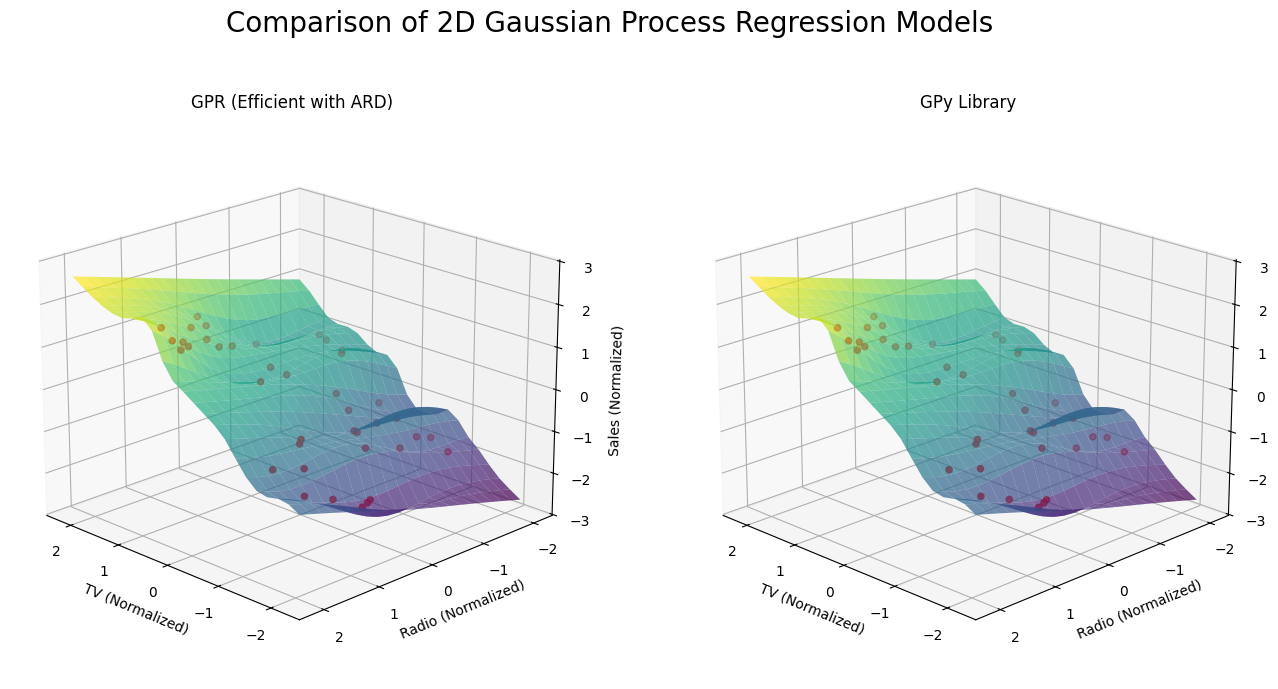

In [13]:
# --- 4. Visualization of GP Surfaces ---

fig = plt.figure(figsize=(16, 8))
models = ['efficient', 'gpy']
titles = ['GPR (Efficient with ARD)', 'GPy Library']

for i, model in enumerate(models):
    ax = fig.add_subplot(1, 2, i + 1, projection='3d')
    mu, _ = predictions[model]
    surface = mu.reshape(x1_grid.shape)
    
    # Plot training data
    ax.scatter(x_train[:, 0], x_train[:, 1], y_train, c='r', marker='o', label='Training Data')
    
    # Plot GP surface
    ax.plot_surface(x1_grid, x2_grid, surface, cmap='viridis', alpha=0.7)
    
    ax.set_title(titles[i])
    ax.set_xlabel('TV (Normalized)')
    ax.set_ylabel('Radio (Normalized)')
    ax.set_zlabel('Sales (Normalized)')
    ax.view_init(elev=20, azim=135) # Set a consistent camera angle

plt.suptitle('Comparison of 2D Gaussian Process Regression Models', fontsize=20)
plt.show()

# --- 5. Execution Time Comparison ---

Total Execution Time for GPR (Efficient with ARD): 0.1015 seconds
Total Execution Time for GPy Library: 0.2061 seconds


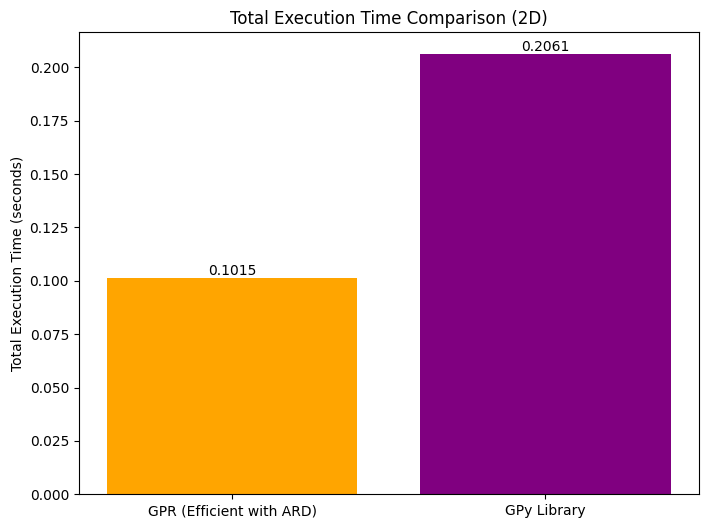

In [14]:
# Extract times
total_time_efficient = times['efficient']
total_time_gpy = times['gpy']

print(f"Total Execution Time for GPR (Efficient with ARD): {total_time_efficient:.4f} seconds")
print(f"Total Execution Time for GPy Library: {total_time_gpy:.4f} seconds")

# Plotting the total execution times
model_names = ['GPR (Efficient with ARD)', 'GPy Library']
time_values = [total_time_efficient, total_time_gpy]
colors = ['orange', 'purple']

plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, time_values, color=colors)
plt.ylabel('Total Execution Time (seconds)')
plt.title('Total Execution Time Comparison (2D)')

# Add time labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.show()